In [3]:
# Model params
# Training for 10 epochs actually overfits the data, however the performance on the test set is consistent
# 5 epochs are usually sufficient
BERT_MODEL = 'bert-base-multilingual-cased'
# Other models:
# For DE: 'bert-base-german-cased'
# For EN: 'bert-base-cased'
MODEL_PATH = '../../model/clf.bin' 
DATA_PATH  = '../../data/tickets_postprp.pkl'

MAX_LEN    = 256
BATCH_SIZE = 16
EPOCHS     = 10
TEST_SPLIT = 0.1
VAL_SPLIT  = 0.5
SEED       = 42

DROPOUT     = 0.3
HIDDEN_SIZE = 768

In [4]:
import pandas as pd
import time
import numpy as np
import transformers

from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt

In [5]:
df = pd.read_pickle(DATA_PATH)
#delete automated tickets
df = df[df["angelegt_von"] != "SOLMAN_BTC "]

In [6]:
#Extract the labels from category and subcategory text as listed below
#Also happens in the data prep script (but rather for visualization in the dashboard)

first_level_subcat  = ["Mandantenrücksetzung ", "Entwicklerschlüssel beantragen ", "Freischaltung einer IP Adresse/Range ", \
                       "Passwortrücksetzung für Masteruser ", "Remote Login ", "H/U-User für Dozenten ", \
                       "EMEA Portal / UAC ", "ERPsim BI ", "Stammdaten/Ansprechpartner ", \
                       "S-User ", "H/U-User für Studenten ", \
                       "Passwortrücksetzung für ERPSim-User ", "ERPsim Demo-System ", "ERPsim Kursmanagement ", \
                       "ERPsim Qualifizierung "]

first_level_cat     = ["SAP GUI"]     

second_level_subcat = ["System Erreichbarkeit ", "Systemverfügbarkeit ", "Systemrücksetzung ", "Systemfehler ", \
                       "Systemkonfiguration /Berechtigungsprobleme ", "Fallstudienproblem ", "TERP10 Anfrage ", \
                       "GBI Fallstudienproblem ", "GBI/GBS Fallstudienproblem ", "Testzugang/Pilot ", "Vertrag ", \
                       "TERP10/TS410 Anfrage ", "Rechnung ", "ERPsim Zahlungsmodalitäten ", "Schulungen "]

second_level_cat    = ["SAP NW", "SAP Netweaver", "TERP 10", "TERP10/TS410", "SAP for Healthcare", "SAP4school", \
                       "SAP Business Warehouse", "sap4school", "erp4school"]

zeros = 0
ones = 0
labels = []
unlabeled_ids = []
for index, row in df.iterrows():
  #first level task
  if any(subcat in str(row["unterkategorietext"]) for subcat in first_level_subcat) or any(cat in str(row["kategorietext"]) for cat in first_level_cat):
    labels.append(0)
    zeros += 1
  else:
    #second level task
    if any(subcat in str(row["unterkategorietext"]) for subcat in second_level_subcat) or any(cat in str(row["kategorietext"]) for cat in second_level_cat):
      labels.append(1)
      ones += 1
    #otherwise: don't use row
    else:
      unlabeled_ids.append(index)

df = df.drop(unlabeled_ids)
labels_np = np.asarray(labels)

print(df.shape)
print("First Level tickets:", zeros)
print("Second Level tickets:", ones)

(3903, 30)
First Level tickets: 2113
Second Level tickets: 1790


In [7]:
# Create tokens for the messages based on our defined bert model
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)

def tokenize(message, tokenizer, max_len=MAX_LEN):
  encoding = tokenizer.encode_plus(
      message,
      add_special_tokens=True,
      max_length=max_len,
      return_token_type_ids=False,
      pad_to_max_length=True,
      return_attention_mask=True,
      return_tensors='pt',
    )
  
  input_ids = encoding['input_ids'].flatten()#.unsqueeze(0)
  attention_mask = encoding['attention_mask'].flatten()#.unsqueeze(0)

  return input_ids, attention_mask

input_ids_list      = []
attention_mask_list = []

counter = 0
for msg in df.initial_message:
  if counter % 1000 == 0:
    print(counter)
  input_ids, attention_mask = tokenize(msg, tokenizer)

  input_ids_list.append(input_ids.numpy())
  attention_mask_list.append(attention_mask.numpy())
  counter += 1

input_ids_np      = np.asarray(input_ids_list)
attention_mask_np = np.asarray(attention_mask_list)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


0


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2190: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


1000
2000
3000


In [8]:
RANDOM_SEED = 42

labels_train, labels_test = train_test_split(
  labels,
  test_size=TEST_SPLIT,
  random_state=RANDOM_SEED
)

input_ids_train, input_ids_test = train_test_split(
  input_ids_np,
  test_size=TEST_SPLIT,
  random_state=RANDOM_SEED
)

attention_mask_train, attention_mask_test = train_test_split(
  attention_mask_np,
  test_size=TEST_SPLIT,
  random_state=RANDOM_SEED
)

#Optional validation split
"""
labels_val, labels_test = train_test_split(
  labels_test,
  test_size=VAL_SPLIT,
  random_state=RANDOM_SEED
)

input_ids_val, input_ids_test = train_test_split(
  input_ids_test,
  test_size=VAL_SPLIT,
  random_state=RANDOM_SEED
)

attention_val_train, attention_mask_test = train_test_split(
  attention_mask_test,
  test_size=VAL_SPLIT,
  random_state=RANDOM_SEED
)
"""

'\nlabels_val, labels_test = train_test_split(\n  labels_test,\n  test_size=VAL_SPLIT,\n  random_state=RANDOM_SEED\n)\n\ninput_ids_val, input_ids_test = train_test_split(\n  input_ids_test,\n  test_size=VAL_SPLIT,\n  random_state=RANDOM_SEED\n)\n\nattention_val_train, attention_mask_test = train_test_split(\n  attention_mask_test,\n  test_size=VAL_SPLIT,\n  random_state=RANDOM_SEED\n)\n'

In [9]:
# Create the dataset for train and test with tokens, attention mask and labels

train_set = torch.utils.data.TensorDataset(
    torch.tensor(input_ids_train, dtype = torch.long),
    torch.tensor(attention_mask_train, dtype = torch.long),
    torch.tensor(labels_train, dtype = torch.long)
)

test_set = torch.utils.data.TensorDataset(
    torch.tensor(input_ids_test, dtype = torch.long),
    torch.tensor(attention_mask_test, dtype = torch.long),
    torch.tensor(labels_test, dtype = torch.long)
)

In [10]:
# Create a dataloader from the two datasets

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size = BATCH_SIZE,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size = BATCH_SIZE,
    shuffle=False,
)

In [11]:
# Define the classfier net

class Classifier(nn.Module):
  def __init__(self):
    super(Classifier, self).__init__()
    self.bert    = BertModel.from_pretrained(BERT_MODEL)
    self.drop    = nn.Dropout(p = DROPOUT)
    self.linear  = nn.Linear(HIDDEN_SIZE, 2)

  def forward(self, input_ids, attention_mask):
    last_hidden_state, pooler_output = \
      self.bert(
        input_ids       = input_ids,
        attention_mask  = attention_mask,
        return_dict     = False
      )

    corrupted = self.drop(pooler_output)
    out       = self.linear(corrupted)
    
    return out

  def encode(self, input_ids, attention_mask):
    return self.bert(
      input_ids       = input_ids,
      attention_mask  = attention_mask,
      return_dict     = False
    )

In [12]:
#Setup clf and move it to GPU

clf = Classifier()

# load model
MODEL_PATH

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

clf = clf.to(device)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


cuda:0


In [13]:
optimizer = AdamW(clf.parameters(), lr=2e-5, correct_bias=False)
loss = nn.CrossEntropyLoss().to(device)

In [14]:
def train():
  clf.train()
  running_loss = []
  labels       = []

  correct_predictions = 0

  for i, data in enumerate(train_loader):
    #if i % 10 == 0:
      #print("Batch", i, "/", len(train_loader))

    input_ids, attention_mask, labels = data
    input_ids, attention_mask, labels = data

    input_ids       = input_ids.to(device)
    attention_mask  = attention_mask.to(device)
    labels          = labels.to(device)

    out = clf(input_ids, attention_mask)

    _, preds = torch.max(out, dim=1)

    correct_predictions += torch.sum(preds == labels)

    l_ce = loss(out, labels)
    running_loss.append(l_ce.item())

    l_ce.backward()
    nn.utils.clip_grad_norm_(clf.parameters(), max_norm=1.0)
    optimizer.step()
    optimizer.zero_grad()

  mean_loss = np.mean(running_loss)
  acc       = correct_predictions.double() / len(labels_train)

  print("Train_Loss:", mean_loss, "Train_ACC", acc.cpu().numpy())

  return mean_loss, acc

def eval():
  clf.eval()
  running_loss = []
  correct_predictions = 0
  with torch.no_grad():
    for i, data in enumerate(test_loader):
      #if i % 10 == 0:
        #print("Batch", i, "of", len(test_loader))

      input_ids, attention_mask, labels = data

      input_ids       = input_ids.to(device)
      attention_mask  = attention_mask.to(device)
      labels          = labels.to(device)

      out = clf(input_ids, attention_mask)

      _, preds = torch.max(out, dim=1)

      correct_predictions += torch.sum(preds == labels)

      l_ce = loss(out, labels)
      running_loss.append(l_ce.item())

  mean_loss = np.mean(running_loss)
  acc       = correct_predictions.double() / len(labels_test)

  print("Test_Loss:", mean_loss, "Test_ACC", acc.cpu().numpy())

  return mean_loss, acc

In [15]:
train_loss_list = []
test_loss_list  = []
train_acc_list  = []
test_acc_list   = []

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  train_loss, train_acc = train()
  test_loss, test_acc   = eval()

  train_loss_list.append(train_loss)
  test_loss_list.append(test_loss)
  train_acc_list.append(train_acc.cpu().numpy())
  test_acc_list.append(test_acc.cpu().numpy())

  print("FINISHED EPOCH")

# Save model
# torch.save(clf.state_dict(), MODEL_PATH)

Epoch 1/10
Train_Loss: 0.5421387233517386 Train_ACC 0.7138382687927106
Test_Loss: 0.544937071800232 Test_ACC 0.7570332480818415
FINISHED EPOCH
Epoch 2/10
Train_Loss: 0.3470915932038968 Train_ACC 0.8613325740318907
Test_Loss: 0.3955573318898678 Test_ACC 0.843989769820972
FINISHED EPOCH
Epoch 3/10
Train_Loss: 0.23225720068439842 Train_ACC 0.9202733485193622
Test_Loss: 0.5098858156614006 Test_ACC 0.8567774936061382
FINISHED EPOCH
Epoch 4/10
Train_Loss: 0.18200792322062295 Train_ACC 0.9447608200455581
Test_Loss: 0.5048136948142201 Test_ACC 0.8618925831202047
FINISHED EPOCH
Epoch 5/10
Train_Loss: 0.12730112906958146 Train_ACC 0.9669703872437357
Test_Loss: 0.6669903958123178 Test_ACC 0.8465473145780051
FINISHED EPOCH
Epoch 6/10
Train_Loss: 0.0927153174913573 Train_ACC 0.9780751708428246
Test_Loss: 0.5983494841959327 Test_ACC 0.864450127877238
FINISHED EPOCH
Epoch 7/10
Train_Loss: 0.07364981941963461 Train_ACC 0.982630979498861
Test_Loss: 0.6999121551564894 Test_ACC 0.8746803069053709
FINISHE

In [26]:
torch.save(clf.state_dict(), f'/content/drive/MyDrive/ML_Downloads/clf.bin')

In [15]:
epochs = list(range(1, 11))

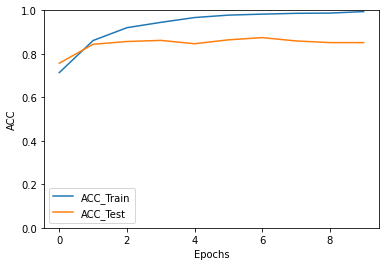

In [21]:
# Data is still overfitting, early stop is also possible, but depends on weight init

plt.plot(train_acc_list, label='ACC_Train')
plt.plot(test_acc_list, label='ACC_Test')
plt.ylabel('ACC')
plt.xlabel('Epochs')
plt.legend()
plt.ylim([0, 1]);
plt.show()
plt.close()

In [ ]:
plt.plot(train_loss_list, label='Loss_Train')
plt.plot(test_loss_list, label='Loss_Test')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend()
plt.ylim([0, 1]);

In [19]:
clf.eval()
predictions = []
with torch.no_grad():
  for i, data in enumerate(test_loader):

    input_ids, attention_mask, labels = data

    input_ids       = input_ids.to(device)
    attention_mask  = attention_mask.to(device)

    out = clf(input_ids, attention_mask)

    _, preds = torch.max(out, dim=1)

    predictions.extend(preds.cpu().numpy())

predictions = np.asarray(predictions)

In [20]:
cm = confusion_matrix(labels_test, predictions, [0, 1])
print(cm)

[[190  33]
 [ 25 143]]
